In [ ]:
!python --version

Updating the linux packages

In [ ]:
!sudo apt update


# Installing python3.11.5 on linux ubuntu

In [ ]:
!sudo apt install -y build-essential zlib1g-dev libncurses5-dev libgdbm-dev libnss3-dev libssl-dev libreadline-dev libffi-dev wget curl


In [ ]:
!wget https://www.python.org/ftp/python/3.11.5/Python-3.11.5.tar.xz


In [ ]:
!tar -xf Python-3.11.5.tar.xz


In [ ]:
!cd Python-3.11.5 && ./configure --enable-optimizations


In [ ]:
!cd Python-3.11.5 && make -j "$(nproc)" && sudo make altinstall


In [ ]:
!python3.11 --version


In [ ]:
!python3.11 --version

In [ ]:
!python3.11 -m venv myenv

# Acitvating the virtual env

In [ ]:
!source myenv/bin/activate

## Activating the virtual environment

In [ ]:
!pip install -r /kaggle/input/cogniguard-requirements/requirements.txt



Installing the necessary files

In [ ]:
!pip install -r /kaggle/input/datasetv2/requirements2.txt --index-url https://pypi.org/simple


### Program.py file for fine tuning the BERT with hyperparameters

Checking for avaiabilty of Gpu

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")


In [3]:
!pip install torchvision torchaudio

In [4]:
!pip install seaborn

### Fine tuning bert model with sweep configuration

In [ ]:
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import wandb
import os

# Initialize wandb
wandb.init(project="bert-finetuning")

# Define hyperparameter ranges for the sweep
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"min": 2e-5, "max": 5e-4},
        "batch_size": {"min": 16, "max": 32},
        "dropout_rate": {"min": 0.1, "max": 0.5}
    },
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="bert-finetuning")

# Preparing and labeling DataSets
file_path = "/kaggle/input/dark-pattern-5k/dp_final_dataset_may_4k.csv"
df = pd.read_csv(file_path)

# encoding the labels
possible_labels = df.Category.unique()
label_dict = {possible_label: index for index, possible_label in enumerate(possible_labels)}
df['label'] = df.Category.replace(label_dict)

# Train and Validation split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)
df['data_type'] = 'not_set'
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

# Bert Tokenizer and Encoding the data 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Define model configuration
model_config = {
    "num_labels": len(label_dict),
    "output_attentions": False,
    "output_hidden_states": False
}

# Define training and evaluation functions
def train(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = inputs["labels"].cpu().numpy()
            predictions.extend(np.argmax(logits, axis=1))
            true_labels.extend(label_ids)
    return total_loss / len(dataloader), predictions, true_labels

# Start the sweep
def sweep_train():
    with wandb.init() as run:
        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", **model_config)
        model.to(device)

        # Initialize optimizer and scheduler
        optimizer = AdamW(model.parameters(), lr=run.config.learning_rate)
        epochs = 5
        total_steps = len(dataset_train) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Initialize dataloaders
        train_dataloader = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=run.config.batch_size)
        val_dataloader = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=run.config.batch_size)

        # Training loop
        for epoch in range(1, epochs + 1):
            # Training
            train_loss = train(model, train_dataloader, optimizer, scheduler, device)
            wandb.log({"train_loss": train_loss}, step=epoch)

            # Evaluation
            val_loss, val_predictions, val_true_labels = evaluate(model, val_dataloader, device)
            val_f1 = f1_score(val_true_labels, val_predictions, average="weighted")
            wandb.log({"val_loss": val_loss, "val_f1": val_f1}, step=epoch)

            # Save the best model
            if epoch == 1 or val_loss < best_val_loss:
                best_val_loss = val_loss
                os.makedirs("saved_models/", exist_ok=True)
                torch.save(model.state_dict(), "saved_models/best_model.pth")

# Run the sweep
wandb.agent(sweep_id, function=sweep_train)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: ll3cx1ri
Sweep URL: https://wandb.ai/solve-ease/bert-finetuning/sweeps/ll3cx1ri


/tmp/ipykernel_34/3649920964.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.Category.replace(label_dict)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: u

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 31/31 [00:05<00:00,  5.84it/s]


train_loss,▁█▆▆▆
val_f1,▁▇███
val_loss,█▄▂▂▁
train_loss,1.73032
val_f1,0.24723
val_loss,1.71821


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: umnlls1e with config:
wandb: 	batch_size: 26
wandb: 	dropout_rate: 0.15627387213298546
wandb: 	learning_rate: 0.00042771014955241926
wandb: Currently logged in as: 4darsh-dev (solve-ease). Use `wandb login --relogin` to force relogin


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


train_loss,▁▅▇██
val_f1,▁▁▁▁▁
val_loss,▁▁███
train_loss,1.81881
val_f1,0.17894
val_loss,1.80613


wandb: Agent Starting Run: pfg11n8t with config:
wandb: 	batch_size: 23
wandb: 	dropout_rate: 0.4854390564998181
wandb: 	learning_rate: 0.00022236442239882763


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 30/30 [00:05<00:00,  5.72it/s]


train_loss,█▃▂▂▁
val_f1,▅█▁█▅
val_loss,▃▁█▁▂
train_loss,0.3937
val_f1,0.83402
val_loss,0.57094


wandb: Agent Starting Run: ydck6rpc with config:
wandb: 	batch_size: 22
wandb: 	dropout_rate: 0.4995273936956902
wandb: 	learning_rate: 0.0001311536528361653


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 31/31 [00:05<00:00,  5.82it/s]


train_loss,█▄▂▂▁
val_f1,▁▄▅▅█
val_loss,▁▁▃▄█
train_loss,0.13601
val_f1,0.8702
val_loss,0.67073


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i1goqtmk with config:
wandb: 	batch_size: 18
wandb: 	dropout_rate: 0.49772651223172193
wandb: 	learning_rate: 0.0003379910163892562


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 38/38 [00:05<00:00,  7.12it/s]


train_loss,▁████
val_f1,█▁▁▁▁
val_loss,▃██▂▁
train_loss,1.78929
val_f1,0.17894
val_loss,1.7832


wandb: Agent Starting Run: qc28a8oh with config:
wandb: 	batch_size: 26
wandb: 	dropout_rate: 0.49281871845769865
wandb: 	learning_rate: 0.00017577307869841494


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


train_loss,█▄▂▁▁
val_f1,▃▇▁█▃
val_loss,▂▁▄▄█
train_loss,0.20112
val_f1,0.87314
val_loss,0.63048


wandb: Agent Starting Run: 2zqsx4bl with config:
wandb: 	batch_size: 25
wandb: 	dropout_rate: 0.40538603967374665
wandb: 	learning_rate: 0.00014040241129637774


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 27/27 [00:05<00:00,  5.03it/s]


train_loss,█▃▂▁▁
val_f1,▅▁▇▆█
val_loss,▁█▁▄▄
train_loss,0.16632
val_f1,0.89573
val_loss,0.54022


wandb: Agent Starting Run: iebq24ey with config:
wandb: 	batch_size: 25
wandb: 	dropout_rate: 0.44841683360836615
wandb: 	learning_rate: 0.0001807041602025989


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 27/27 [00:05<00:00,  5.03it/s]


train_loss,█▃▂▁▁
val_f1,▁▅█▇▆
val_loss,▆▅▁▅█
train_loss,0.23264
val_f1,0.87416
val_loss,0.54149


wandb: Agent Starting Run: m720ax83 with config:
wandb: 	batch_size: 31
wandb: 	dropout_rate: 0.41209141745396705
wandb: 	learning_rate: 2.420265544655685e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluation: 100%|██████████| 22/22 [00:05<00:00,  4.20it/s]


train_loss,█▃▂▁▁
val_f1,▁▆▆▇█
val_loss,█▂▂▁▁
train_loss,0.07185
val_f1,0.92264
val_loss,0.35339


wandb: Agent Starting Run: 7mvslyhv with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.33016627794539266
wandb: 	learning_rate: 2.092588874429556e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:  95%|█████████▌| 114/120 [01:24<00:04,  1.35it/s]

### Evaluating the model epoch5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating:   0%|          | 0/202 [00:00<?, ?sample/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or 

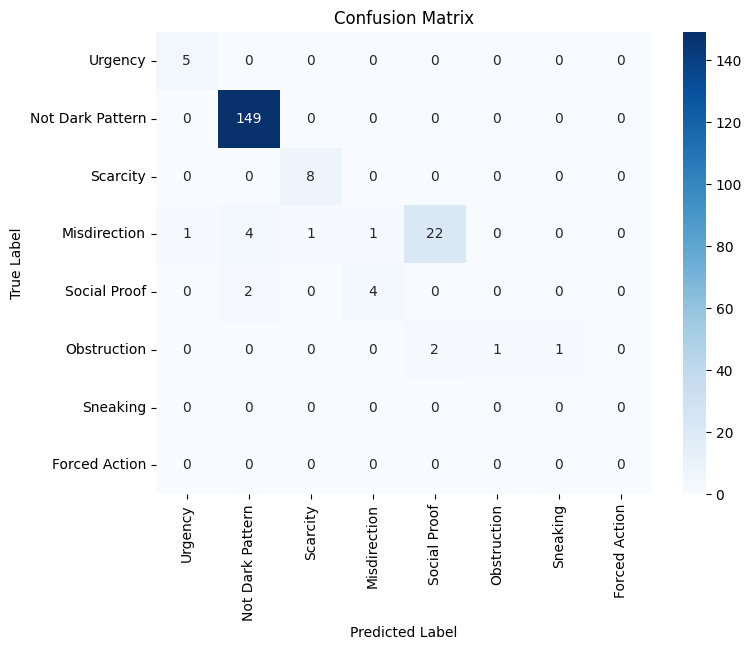

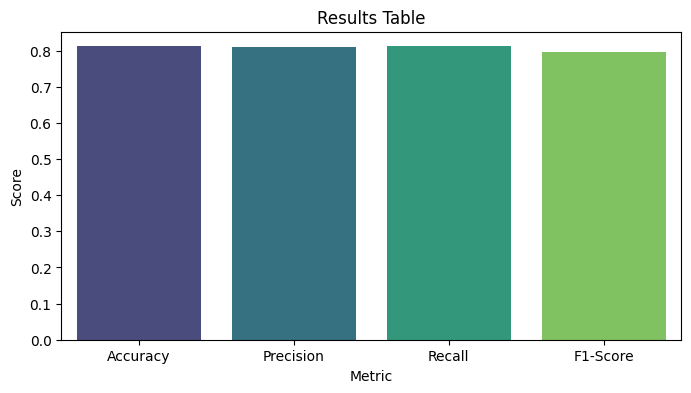

Confusion Matrix:
[[  5   0   0   0   0   0   0   0]
 [  0 149   0   0   0   0   0   0]
 [  0   0   8   0   0   0   0   0]
 [  1   4   1   1  22   0   0   0]
 [  0   2   0   4   0   0   0   0]
 [  0   0   0   0   2   1   1   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]

Results Table:
      Metric     Score
0   Accuracy  0.811881
1  Precision  0.808871
2     Recall  0.811881
3   F1-Score  0.796837

Total Time Taken: 3.15 seconds


In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
label_dict = {"Urgency": 0, "Not Dark Pattern": 1, "Scarcity": 2, "Misdirection": 3, "Social Proof": 4, "Obstruction": 5, "Sneaking": 6, "Forced Action": 7}
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_dict))
model = model.to(device)  # Move model to GPU if available

# Load fine-tuned weights
fine_tuned_model_path = "/kaggle/working/finetuned_BERT_epoch_5.model"
model.load_state_dict(torch.load(fine_tuned_model_path, map_location=device))

# Preprocess the new text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to map numeric label to dark pattern name
def get_dark_pattern_name(label):
    reverse_label_dict = {v: k for k, v in label_dict.items()}
    return reverse_label_dict[label]

def find_dark_pattern(text_predict):
    encoded_text = tokenizer.encode_plus(
        text_predict,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )
    encoded_text = {key: val.to(device) for key, val in encoded_text.items()}  # Move tensors to GPU

    # Making the predictions
    model.eval()

    with torch.no_grad():
        inputs = {
            'input_ids': encoded_text['input_ids'],
            'attention_mask': encoded_text['attention_mask']
        }
        outputs = model(**inputs)

    predictions = outputs.logits

    # Post-process the predictions
    probabilities = torch.nn.functional.softmax(predictions, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1).item()

    return get_dark_pattern_name(predicted_label)


# Load the dataset
file_path = "/kaggle/input/evaluation-dataset-dark-pattern-200/evaluate_dp_dataset.csv"
df = pd.read_csv(file_path)


# Record the start time
start_time = time.time()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Use tqdm to create a progress bar
for _, row in tqdm(df.iterrows(), desc="Evaluating", unit="sample", total=len(df)):
    text_to_predict = row['Title']
    true_label = row['Category']

    # Make prediction
    predicted_darkp = find_dark_pattern(text_to_predict)

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_darkp)

# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time = end_time - start_time

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and f1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=list(label_dict.keys()))

# Display results in a table
results_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score": [accuracy, precision, recall, f1]
})

# Plot a colorful confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot the results table
plt.figure(figsize=(8, 4))
sns.barplot(x='Metric', y='Score', data=results_table, palette='viridis')
plt.title('Results Table')
plt.show()

print("Confusion Matrix:")
print(conf_matrix)

print("\nResults Table:")
print(results_table)

print(f"\nTotal Time Taken: {total_time:.2f} seconds")


### Traning BERt for 5epochs v2

In [ ]:
# Implementing TowardsDS's BERT model for dark pattern detection
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import random
import wandb
import os

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Wandb
wandb.init(project="dark-pattern-detection")

# Load and preprocess the data
file_path = "/kaggle/input/dark-pattern-dataset/dp_final_dataset_april_3k.csv"
df = pd.read_csv(file_path)

# Encode the labels
possible_labels = df["Category"].unique()
label_dict = {label: index for index, label in enumerate(possible_labels)}
df["label"] = df["Category"].replace(label_dict)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.15,
    random_state=42,
    stratify=df.label.values,
)
df["data_type"] = ["not_set"] * df.shape[0]
df.loc[X_train, "data_type"] = "train"
df.loc[X_val, "data_type"] = "val"

# Tokenize and encode the data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == "train"].Title.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors="pt",
).to(device)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == "val"].Title.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors="pt",
).to(device)

input_ids_train = encoded_data_train["input_ids"]
attention_masks_train = encoded_data_train["attention_mask"]
labels_train = torch.tensor(df[df.data_type == "train"].label.values).to(device)

input_ids_val = encoded_data_val["input_ids"]
attention_masks_val = encoded_data_val["attention_mask"]
labels_val = torch.tensor(df[df.data_type == "val"].label.values).to(device)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Load the pretrained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_dict), output_attentions=False, output_hidden_states=False
)
model = model.to(device)

# Define data loaders
batch_size = 32
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size,
)
dataloader_validation = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=batch_size,
)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train) * epochs
)

# Define performance metrics
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average="weighted")


def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        wandb.log(
            {
                f"Class: {label_dict_inverse[label]}": wandb.Table(
                    data=[
                        {"Accuracy": len(y_preds[y_preds == label]) / len(y_true), "Class": label_dict_inverse[label]}
                    ]
                )
            }
        )

# Training loop for BERT
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2],
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals


for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch}", leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2],
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix(
            {"training_loss": f"{loss.item() / len(batch):.3f}", "epoch": epoch}
        )
        wandb.log({"Training Loss": loss.item() / len(batch)})
    # Create the directory if it doesn't exist
    os.makedirs("fine_tuned_bert", exist_ok=True)
    torch.save(model.state_dict(), f"fine_tuned_bert/finetuned_BERT_epoch_{epoch}.model")
    wandb.log({"Epoch": epoch})
    loss_train_avg = loss_train_total / len(dataloader_train)
    wandb.log({"Training Loss": loss_train_avg})
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    wandb.log({"Validation Loss": val_loss, "F1 Score (Weighted)": val_f1})

# Load and evaluate the fine-tuned BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_dict), output_attentions=False, output_hidden_states=False
)
model = model.to(device)
model.load_state_dict(
    torch.load("fine_tuned_bert/finetuned_BERT_epoch_1.model")
)
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)


## Downloading the output files

In [ ]:
<a href="kaggle/working/fine_tuned_bert3/finetuned_BERT_epoch_5.model"> Download File </a>

In [ ]:
from IPython.display import FileLink
FileLink('kaggle/working/fine_tuned_bert3/finetuned_BERT_epoch_5.model')


### 19March Fine-Tune Bert epoch5 

In [ ]:
import torch
from tqdm import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import random
import os  # Import os module for directory creation

# Reading data
file_path = "/kaggle/input/dark-pattern-dataset-2250-19march/dp_dataset_100_19March.csv"
df = pd.read_csv(file_path)

# Function to evaluate the model
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


# Encoding the labels
possible_labels = df.Category.unique()
label_dict = {possible_label: index for index, possible_label in enumerate(possible_labels)}
df['label'] = df.Category.replace(label_dict)

# Train and Validation split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)
df['data_type'] = 'not_set'
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

# Bert Tokenizer and Encoding the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Title.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Bert Pretrained Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# Data Loaders
batch_size = 3
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

# Performance Metrics
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

# Create directory if it doesn't exist
os.makedirs("fine_tuned_bert3", exist_ok=True)

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    torch.save(model.state_dict(), f'fine_tuned_bert3/finetuned_BERT_epoch_{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')